In [14]:
import numpy as np
import seaborn as sns
from scipy import stats, signal
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime as dt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

In [188]:
MAX_EPOCHS = 50

def buildDataframe(countyString):
    #load data, renames columns, converts timestamps to datetime, & sets datetime as index
    dfMax = pd.read_csv(countyString+"-tmax-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMax['Date'] = pd.to_datetime(dfMax['Date'], yearfirst = True, format = "%Y%m")
    dfMax = dfMax.rename(columns={dfMax.columns[1]:'MaxTempF'})
    dfMax = dfMax.rename(columns={dfMax.columns[2]:'MaxAnomalyF'})
    dfMax = dfMax.set_index(dfMax['Date'])
    del dfMax['Date']

    dfMin = pd.read_csv(countyString+"-tmin-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfMin['Date'] = pd.to_datetime(dfMin['Date'], yearfirst = True, format = "%Y%m")
    dfMin = dfMin.rename(columns={dfMin.columns[1]:'MinTempF'})
    dfMin = dfMin.rename(columns={dfMin.columns[2]:'MinAnomalyF'})
    dfMin = dfMin.set_index(dfMin['Date'])
    del dfMin['Date']

    dfAvg = pd.read_csv(countyString+"-tavg-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfAvg['Date'] = pd.to_datetime(dfAvg['Date'], yearfirst = True, format = "%Y%m")
    dfAvg = dfAvg.rename(columns={dfAvg.columns[1]:'AvgTempF'})
    dfAvg = dfAvg.rename(columns={dfAvg.columns[2]:'AvgAnomalyF'})
    dfAvg = dfAvg.set_index(dfAvg['Date'])
    del dfAvg['Date']

    dfPrecip = pd.read_csv(countyString+"-pcp-all-10-1895-2021.csv", parse_dates=True,skiprows=4)
    dfPrecip['Date'] = pd.to_datetime(dfPrecip['Date'], yearfirst = True, format = "%Y%m")
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[1]:'PrecipitationIn'})
    dfPrecip = dfPrecip.rename(columns={dfPrecip.columns[2]:'PrecipAnomalyIn'})
    dfPrecip = dfPrecip.set_index(dfPrecip['Date'])
    del dfPrecip['Date']

    df = pd.concat([dfMax, dfMin, dfPrecip, dfAvg], axis=1)
    return df

def split_normalizeData(df):
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(df)
    train_df = df[0:int(n*0.7)]
    val_df = df[int(n*0.7):int(n*0.9)]
    test_df = df[int(n*0.9):]
    num_features = df.shape[1]
    train_mean = train_df.mean()
    train_std = train_df.std()
    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    return train_df, val_df, test_df

def compile_and_fit(model, window, patience=2):
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val)
    return history

class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df, val_df, test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
  
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
     # Slicing doesn't preserve static shape information, so set the shapes
     # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels
  
  def plot(self, model=None, plot_col='AvgTempF', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_n, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index], marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)
        if n == 0:
            plt.legend()
    plt.xlabel('Time [h]')
    
  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=data, targets=None,
      sequence_length=self.total_window_size, sequence_stride=1, shuffle=True, batch_size=32,)
    ds = ds.map(self.split_window)
    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result

class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [206]:
dfWayne = buildDataframe('MI-163')
dfCook = buildDataframe('IL-031')
dfNueces = buildDataframe('TX-355')
train_Wayne, val_Wayne, test_Wayne = split_normalizeData(dfWayne)
train_Cook, val_Cook, test_Cook = split_normalizeData(dfCook)
train_Nueces, val_Nueces, test_Nueces = split_normalizeData(dfNueces)

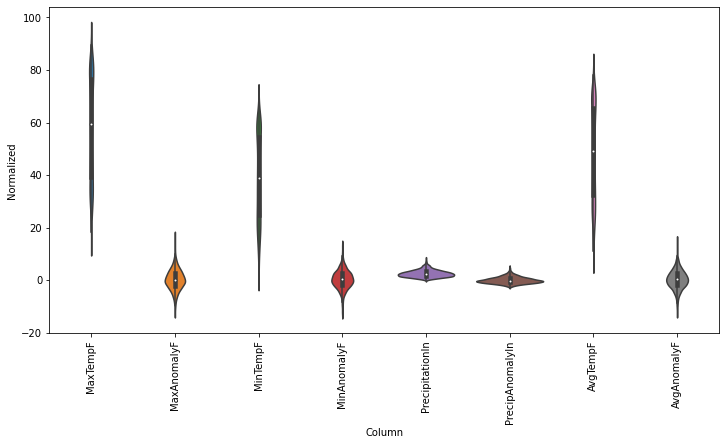

In [190]:
train_mean = train_Wayne.mean()
train_std = train_Wayne.std()
df_std = (dfWayne - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfWayne.keys(), rotation=90)

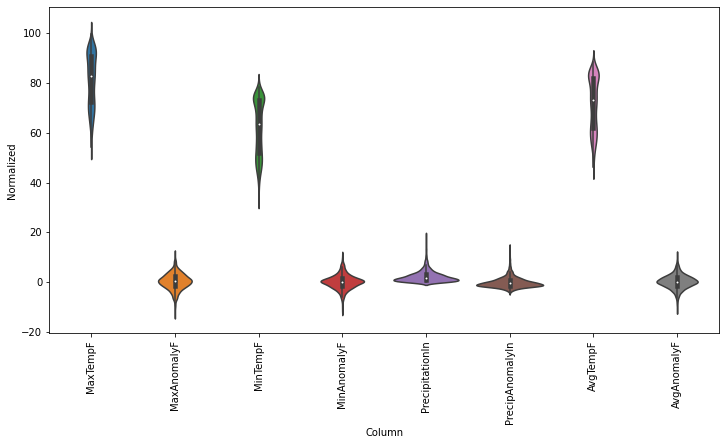

In [208]:
train_mean = train_Nueces.mean()
train_std = train_Nueces.std()
df_std = (dfNueces - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(dfNueces.keys(), rotation=90)

In [209]:
w_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_3m = WindowGenerator(input_width=3, label_width=3, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_1y = WindowGenerator(input_width=12, label_width=12, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_2y = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
w_5y = WindowGenerator(input_width=60, label_width=60, shift=1, train_df=train_Wayne, val_df=val_Wayne, 
                     test_df=test_Wayne, label_columns=['AvgTempF'])
c_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_3m = WindowGenerator(input_width=3, label_width=3, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_1y = WindowGenerator(input_width=12, label_width=12, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_2y = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
c_5y = WindowGenerator(input_width=60, label_width=60, shift=1, train_df=train_Cook, val_df=val_Cook, 
                     test_df=test_Cook, label_columns=['AvgTempF'])
n_1m = WindowGenerator(input_width=1, label_width=1, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_3m = WindowGenerator(input_width=3, label_width=3, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_1y = WindowGenerator(input_width=12, label_width=12, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_2y = WindowGenerator(input_width=24, label_width=24, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])
n_5y = WindowGenerator(input_width=60, label_width=60, shift=1, train_df=train_Nueces, val_df=val_Nueces, 
                     test_df=test_Nueces, label_columns=['AvgTempF'])

10/10 [==============================] - 0s 1ms/step - loss: 0.3018 - mean_absolute_error: 0.4771


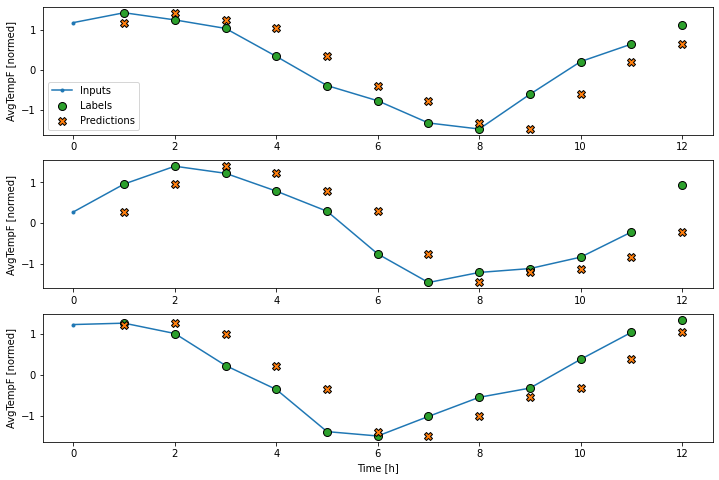

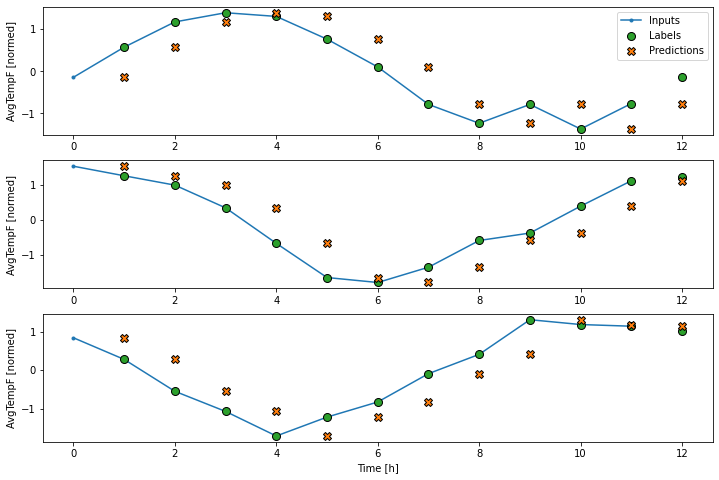

In [211]:
baseline = Baseline(label_index=column_indices['AvgTempF'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(w_1m.val)
performance['Baseline'] = baseline.evaluate(w_1m.test, verbose=0)
w_1y.plot(baseline)
c_1y.plot(baseline)

Input shape: (32, 1, 8)
Output shape: (32, 1, 1)
Epoch 1/50
34/34 [==============================] - 0s 6ms/step - loss: 2.8003 - mean_absolute_error: 1.3934 - val_loss: 3.0255 - val_mean_absolute_error: 1.3701
Epoch 2/50
34/34 [==============================] - 0s 3ms/step - loss: 2.4342 - mean_absolute_error: 1.3020 - val_loss: 2.6129 - val_mean_absolute_error: 1.2776
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 2.1170 - mean_absolute_error: 1.2164 - val_loss: 2.2522 - val_mean_absolute_error: 1.1908
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 1.8386 - mean_absolute_error: 1.1358 - val_loss: 1.9447 - val_mean_absolute_error: 1.1108
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 1.5961 - mean_absolute_error: 1.0605 - val_loss: 1.6782 - val_mean_absolute_error: 1.0367
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 1.3841 - mean_absolute_error: 0.9901 - val_loss: 1.4410 - val_mean_ab

10/10 [==============================] - 0s 901us/step - loss: 0.3418 - mean_absolute_error: 0.5147


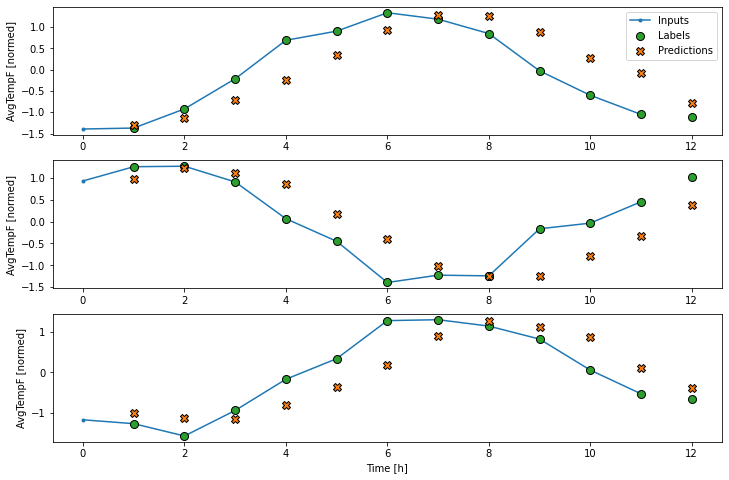

In [194]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', w_1m.example[0].shape)
print('Output shape:', linear(w_1m.example[0]).shape)
history = compile_and_fit(linear, w_1m)
val_performance['Linear'] = linear.evaluate(w_1m.val)
performance['Linear'] = linear.evaluate(w_1m.test, verbose=0)
w_1y.plot(linear)

Epoch 1/50
34/34 [==============================] - 0s 9ms/step - loss: 0.4535 - mean_absolute_error: 0.5668 - val_loss: 0.3105 - val_mean_absolute_error: 0.4782
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2594 - mean_absolute_error: 0.4421 - val_loss: 0.2590 - val_mean_absolute_error: 0.4432
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2372 - mean_absolute_error: 0.4228 - val_loss: 0.2435 - val_mean_absolute_error: 0.4298
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2229 - mean_absolute_error: 0.4050 - val_loss: 0.2258 - val_mean_absolute_error: 0.4112
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2054 - mean_absolute_error: 0.3856 - val_loss: 0.2096 - val_mean_absolute_error: 0.3905
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.1885 - mean_absolute_error: 0.3653 - val_loss: 0.1966 - val_mean_absolute_error: 0.3779
Epoch 7/50
34/34 [==========

10/10 [==============================] - 0s 1ms/step - loss: 0.0588 - mean_absolute_error: 0.1923


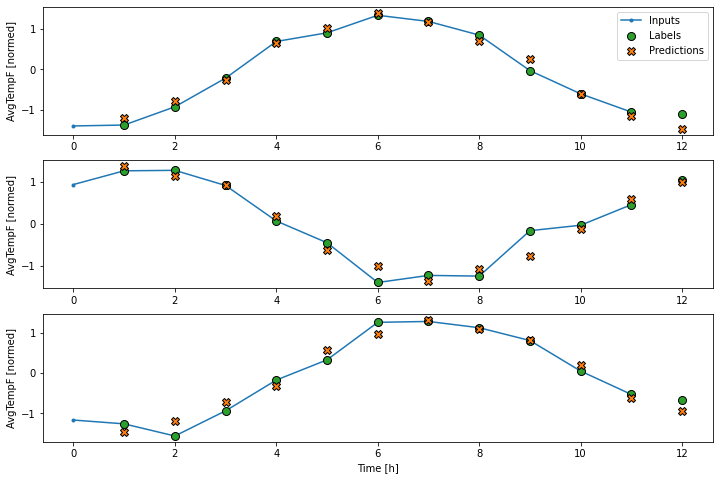

In [195]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, w_1m)

val_performance['Dense'] = dense.evaluate(w_1m.val)
performance['Dense'] = dense.evaluate(w_1m.test, verbose=0)
w_1y.plot(dense)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)
Epoch 1/50
34/34 [==============================] - 0s 6ms/step - loss: 0.6964 - mean_absolute_error: 0.6960 - val_loss: 0.3035 - val_mean_absolute_error: 0.4350
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2857 - mean_absolute_error: 0.4252 - val_loss: 0.2239 - val_mean_absolute_error: 0.3769
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2283 - mean_absolute_error: 0.3816 - val_loss: 0.2075 - val_mean_absolute_error: 0.3618
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2130 - mean_absolute_error: 0.3669 - val_loss: 0.1990 - val_mean_absolute_error: 0.3558
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2052 - mean_absolute_error: 0.3610 - val_loss: 0.1950 - val_mean_absolute_error: 0.3534
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2020 - mean_absolute_error: 0.3567 - val_loss: 0.1926 - val_mean_ab

10/10 [==============================] - 0s 905us/step - loss: 0.1800 - mean_absolute_error: 0.3384


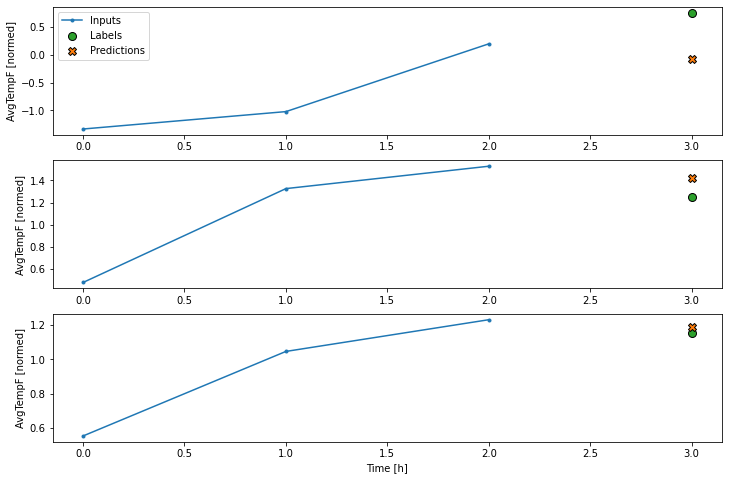

In [202]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    train_df=train_Wayne, val_df=val_Wayne, test_df=test_Wayne,
    label_columns=['AvgTempF'])

multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])])
print('Input shape:', w_3m.example[0].shape)
print('Output shape:', multi_step_dense(w_3m.example[0]).shape)
history = compile_and_fit(multi_step_dense, w_3m)
val_performance['Multi step dense'] = multi_step_dense.evaluate(w_3m.val)
performance['Multi step dense'] = multi_step_dense.evaluate(w_3m.test, verbose=0)
conv_window.plot(multi_step_dense)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)
Epoch 1/50
34/34 [==============================] - 0s 6ms/step - loss: 0.4799 - mean_absolute_error: 0.5784 - val_loss: 0.3003 - val_mean_absolute_error: 0.4446
Epoch 2/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2655 - mean_absolute_error: 0.4157 - val_loss: 0.2277 - val_mean_absolute_error: 0.3877
Epoch 3/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2246 - mean_absolute_error: 0.3810 - val_loss: 0.2056 - val_mean_absolute_error: 0.3636
Epoch 4/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2103 - mean_absolute_error: 0.3658 - val_loss: 0.1964 - val_mean_absolute_error: 0.3543
Epoch 5/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2038 - mean_absolute_error: 0.3606 - val_loss: 0.1922 - val_mean_absolute_error: 0.3489
Epoch 6/50
34/34 [==============================] - 0s 4ms/step - loss: 0.2008 - mean_absolute_error: 0.3576 - val_loss: 0.1904 - val_mean_ab

10/10 [==============================] - 0s 1ms/step - loss: 0.1799 - mean_absolute_error: 0.3420


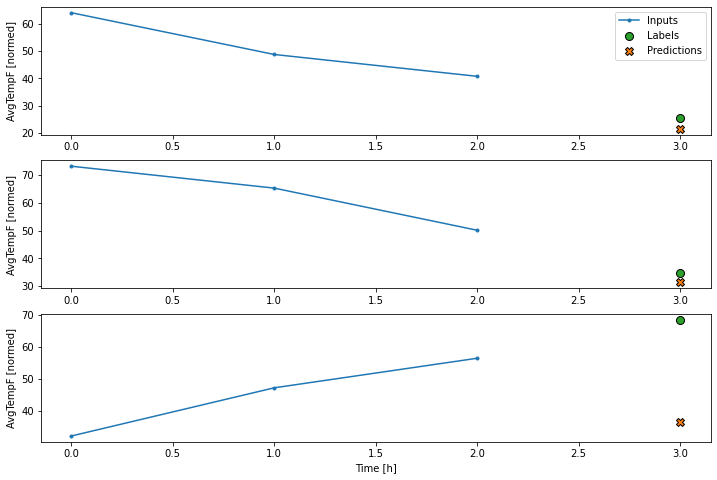

In [167]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])
print('Input shape:', w_3m.example[0].shape)
print('Output shape:', multi_step_dense(w_3m.example[0]).shape)
history = compile_and_fit(multi_step_dense, w_3m)
val_performance['Multi step dense'] = multi_step_dense.evaluate(w_3m.val)
performance['Multi step dense'] = multi_step_dense.evaluate(w_3m.test, verbose=0)
conv_window.plot(multi_step_dense)

Input shape: (32, 3, 8)
Output shape: (32, 1, 1)
Epoch 1/50
34/34 [==============================] - 0s 8ms/step - loss: 0.6270 - mean_absolute_error: 0.6490 - val_loss: 0.3388 - val_mean_absolute_error: 0.4529
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2799 - mean_absolute_error: 0.4236 - val_loss: 0.2194 - val_mean_absolute_error: 0.3806
Epoch 3/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2205 - mean_absolute_error: 0.3784 - val_loss: 0.1957 - val_mean_absolute_error: 0.3582
Epoch 4/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2068 - mean_absolute_error: 0.3642 - val_loss: 0.1902 - val_mean_absolute_error: 0.3518
Epoch 5/50
34/34 [==============================] - 0s 3ms/step - loss: 0.2019 - mean_absolute_error: 0.3589 - val_loss: 0.1875 - val_mean_absolute_error: 0.3484
Epoch 6/50
34/34 [==============================] - 0s 3ms/step - loss: 0.1989 - mean_absolute_error: 0.3559 - val_loss: 0.1857 - val_mean_ab

10/10 [==============================] - 0s 1ms/step - loss: 0.1805 - mean_absolute_error: 0.3382


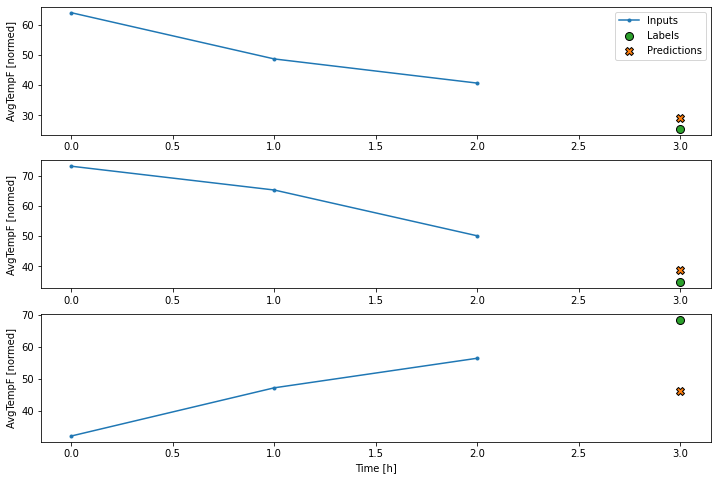

In [174]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])
print('Input shape:', w_3m.example[0].shape)
print('Output shape:', conv_model(w_3m.example[0]).shape)
history = compile_and_fit(conv_model, w_3m)
val_performance['Conv'] = conv_model.evaluate(w_3m.val)
performance['Conv'] = conv_model.evaluate(w_3m.test, verbose=0)
w_1y.plot(conv_model)

Input shape: (32, 26, 8)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


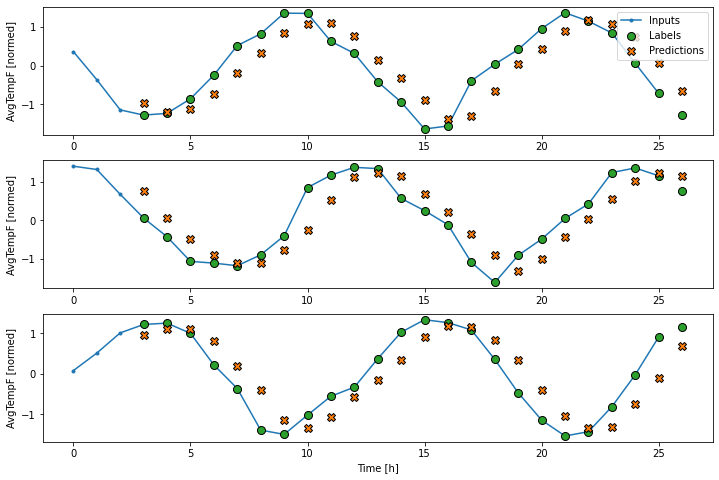

In [203]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    train_df=train_Wayne, val_df=val_Wayne, test_df=test_Wayne,
    label_columns=['AvgTempF'])

print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)
wide_conv_window.plot(conv_model)

Input shape: (32, 3, 8)
Output shape: (32, 3, 1)
Epoch 1/50
34/34 [==============================] - 1s 20ms/step - loss: 0.9052 - mean_absolute_error: 0.8411 - val_loss: 0.6722 - val_mean_absolute_error: 0.7238
Epoch 2/50
34/34 [==============================] - 0s 5ms/step - loss: 0.6191 - mean_absolute_error: 0.6968 - val_loss: 0.5256 - val_mean_absolute_error: 0.6386
Epoch 3/50
34/34 [==============================] - 0s 5ms/step - loss: 0.4773 - mean_absolute_error: 0.6091 - val_loss: 0.4107 - val_mean_absolute_error: 0.5648
Epoch 4/50
34/34 [==============================] - 0s 5ms/step - loss: 0.3547 - mean_absolute_error: 0.5226 - val_loss: 0.3013 - val_mean_absolute_error: 0.4813
Epoch 5/50
34/34 [==============================] - 0s 5ms/step - loss: 0.2526 - mean_absolute_error: 0.4328 - val_loss: 0.2176 - val_mean_absolute_error: 0.3997
Epoch 6/50
34/34 [==============================] - 0s 5ms/step - loss: 0.1877 - mean_absolute_error: 0.3632 - val_loss: 0.1743 - val_mean_a

10/10 [==============================] - 0s 2ms/step - loss: 0.0940 - mean_absolute_error: 0.2390


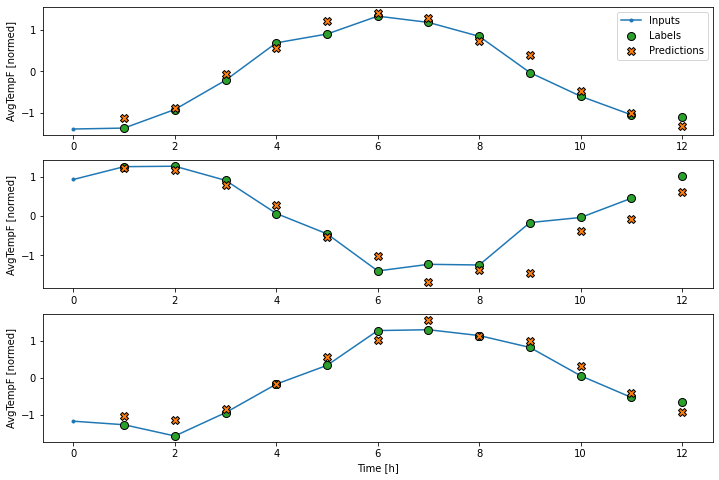

In [204]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)])
print('Input shape:', w_3m.example[0].shape)
print('Output shape:', lstm_model(w_3m.example[0]).shape)
history = compile_and_fit(lstm_model, w_3m)
val_performance['LSTM'] = lstm_model.evaluate(w_3m.val)
performance['LSTM'] = lstm_model.evaluate(w_3m.test, verbose=0)
w_1y.plot(lstm_model)

Input shape: (32, 12, 8)
Output shape: (32, 12, 1)
Epoch 1/50
33/33 [==============================] - 1s 24ms/step - loss: 0.6749 - mean_absolute_error: 0.7188 - val_loss: 0.3949 - val_mean_absolute_error: 0.5360
Epoch 2/50
33/33 [==============================] - 0s 7ms/step - loss: 0.2744 - mean_absolute_error: 0.4210 - val_loss: 0.1849 - val_mean_absolute_error: 0.3367
Epoch 3/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1579 - mean_absolute_error: 0.3044 - val_loss: 0.1309 - val_mean_absolute_error: 0.2782
Epoch 4/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1187 - mean_absolute_error: 0.2607 - val_loss: 0.1102 - val_mean_absolute_error: 0.2535
Epoch 5/50
33/33 [==============================] - 0s 7ms/step - loss: 0.1013 - mean_absolute_error: 0.2392 - val_loss: 0.0993 - val_mean_absolute_error: 0.2394
Epoch 6/50
33/33 [==============================] - 0s 8ms/step - loss: 0.0908 - mean_absolute_error: 0.2253 - val_loss: 0.0913 - val_mean

10/10 [==============================] - 0s 2ms/step - loss: 0.0626 - mean_absolute_error: 0.1897


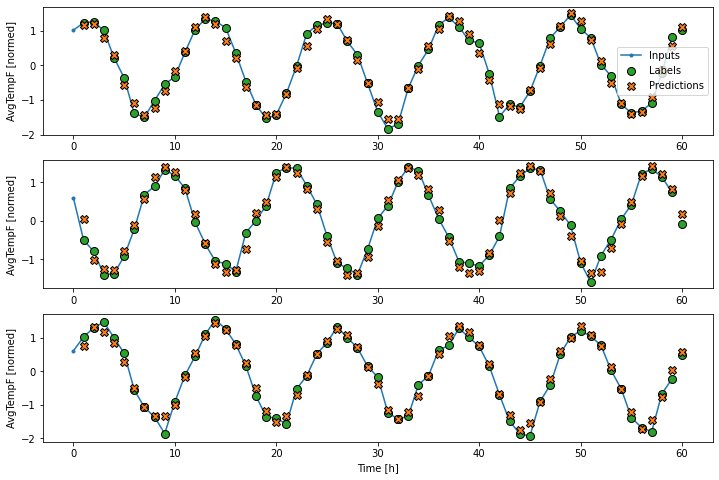

In [184]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])
print('Input shape:', w_1y.example[0].shape)
print('Output shape:', lstm_model(w_1y.example[0]).shape)
history = compile_and_fit(lstm_model, w_1y)
val_performance['LSTM'] = lstm_model.evaluate(w_1y.val)
performance['LSTM'] = lstm_model.evaluate(w_1y.test, verbose=0)
w_5y.plot(lstm_model)

Baseline    : 0.4705
Linear      : 0.5115
Dense       : 0.2297
Multi step dense: 0.3397
LSTM        : 0.2595


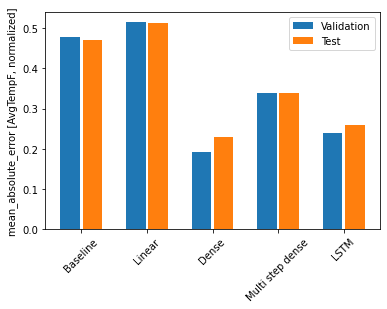

In [205]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [AvgTempF, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')